# Cover

## Imports

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# For RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Accuracy Score and Loss data
from sklearn.metrics import accuracy_score, mean_squared_error

# Train Test Split
from sklearn.model_selection import train_test_split

## Reading CSV

In [2]:
df = pd.read_csv("log2.csv")

## Structure of the Dataset

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow


## Data Understanding

- Action is the Dependent Variable, while the others columns are independent variables;
- The dataset has 65k+ rows and 12 columns;
- No null values;
- 8k+ duplicated rows (that weren't dropped because some info or pattern can be lost with it);

In [4]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [5]:
df['Elapsed Time (sec)'].max()

10824

In [6]:
df.shape

(65532, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Bytes                 65532 non-null  int64 
 5   Bytes Sent            65532 non-null  int64 
 6   Bytes Received        65532 non-null  int64 
 7   Packets               65532 non-null  int64 
 8   Elapsed Time (sec)    65532 non-null  int64 
 9   pkts_sent             65532 non-null  int64 
 10  pkts_received         65532 non-null  int64 
 11  Action                65532 non-null  object
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [8]:
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
Action                  0
dtype: int64

In [9]:
df.duplicated().sum() # remove duplicated rows?

8362

In [10]:
df.dtypes

Source Port              int64
Destination Port         int64
NAT Source Port          int64
NAT Destination Port     int64
Bytes                    int64
Bytes Sent               int64
Bytes Received           int64
Packets                  int64
Elapsed Time (sec)       int64
pkts_sent                int64
pkts_received            int64
Action                  object
dtype: object

## Looking for outliers

Below we have the original values of the dataframe for the numerical values.

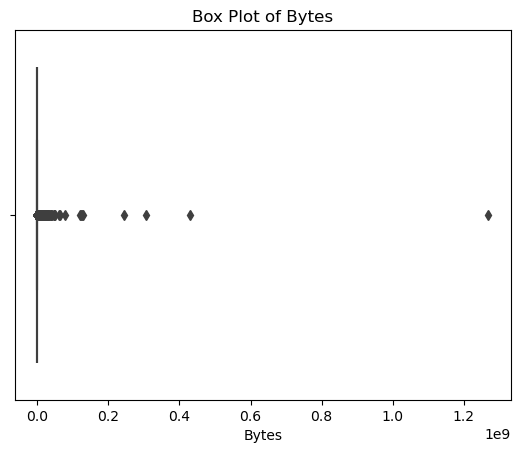

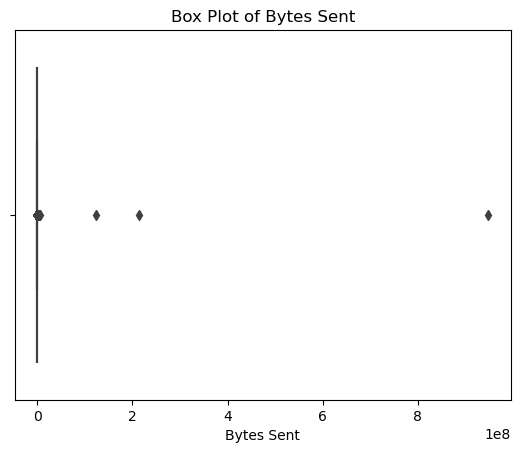

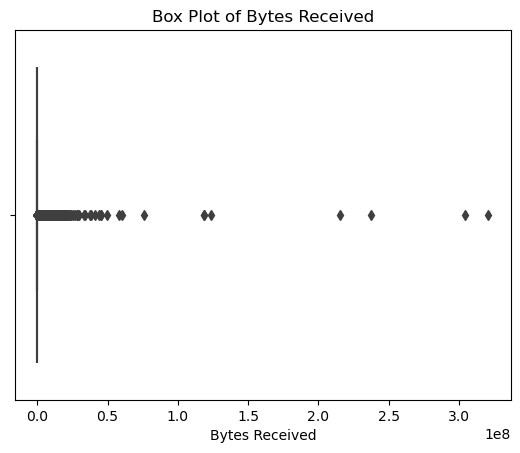

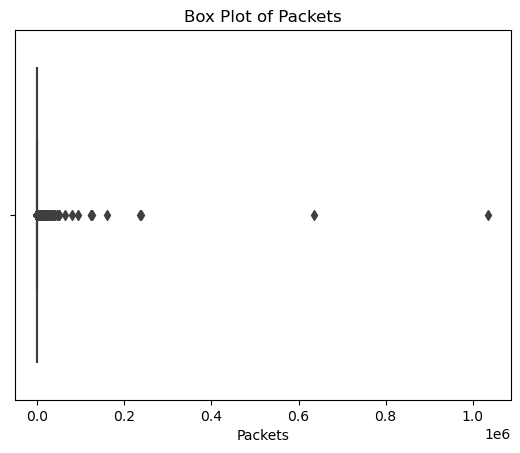

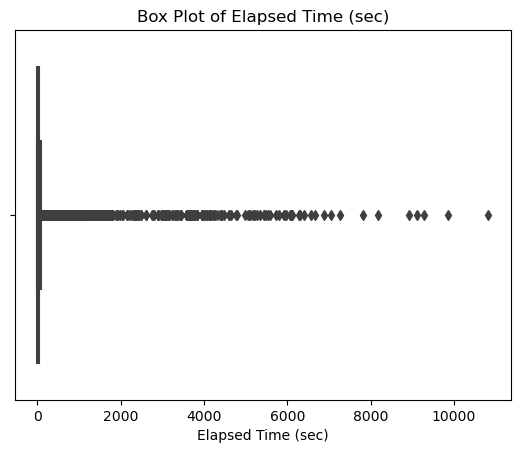

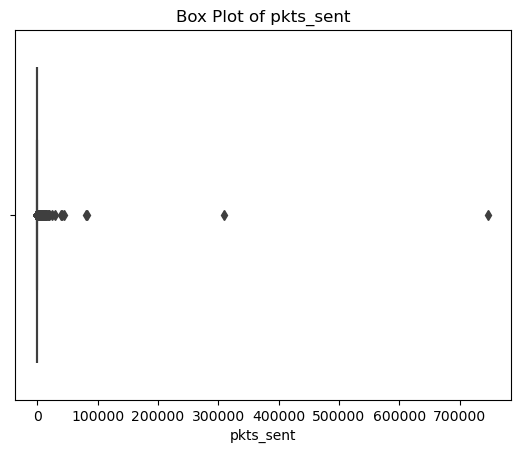

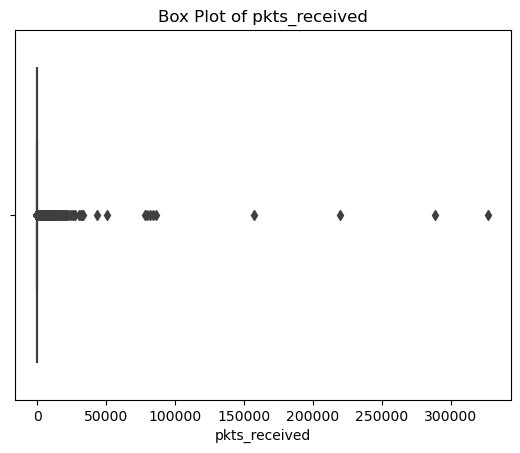

In [11]:
numerical_columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

for column in numerical_columns:
    sns.boxplot(x=column, data=df)
    plt.xlabel(column)
    plt.title(f'Box Plot of {column}')
    plt.show()

# Z-Scores for removing Outliers

Here we first select only numerical columns for the data cleaning. I had done beforehand a very slight removal of outliers just by vizualisation of the data points onto the box plots, but decided to use the z-score values to be more aggressive and effective in my data cleaning process. 

Meanwhile my first manual cleaning cleaned only 40 data points, based on a very conservative approach, this cleaning removed around 3k of rows. I chose to use the df_clean moving on forward, trusting the method would be more effective that just visualisation + manual removal of outliers.

In [12]:
numerical_cols = df.select_dtypes(include=[int]).columns

z_scores = stats.zscore(df[numerical_cols])
threshold = 3
df_clean = df[(z_scores < threshold).all(axis=1)]


print("Original shape:", df.shape)
print("Shape after removing outliers:", df_clean.shape)

Original shape: (65532, 12)
Shape after removing outliers: (62293, 12)


## Box plots of the df_clean dataset

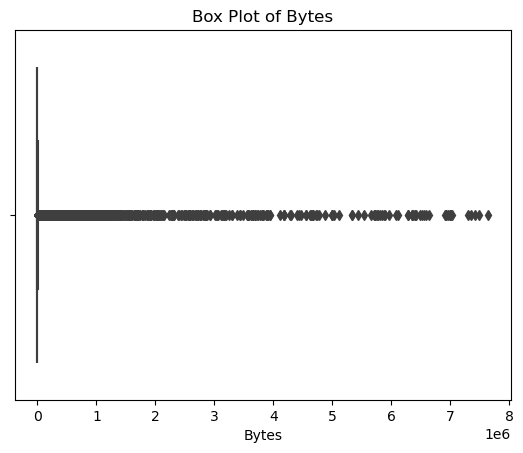

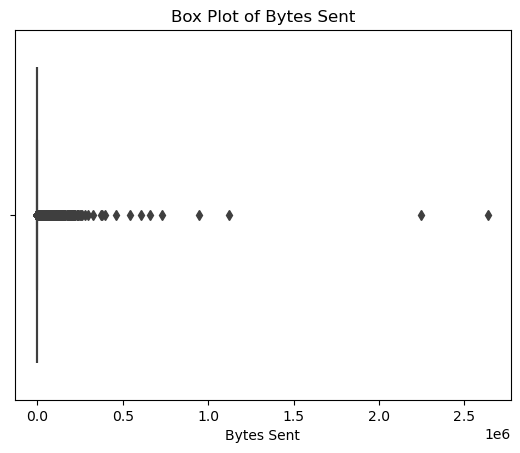

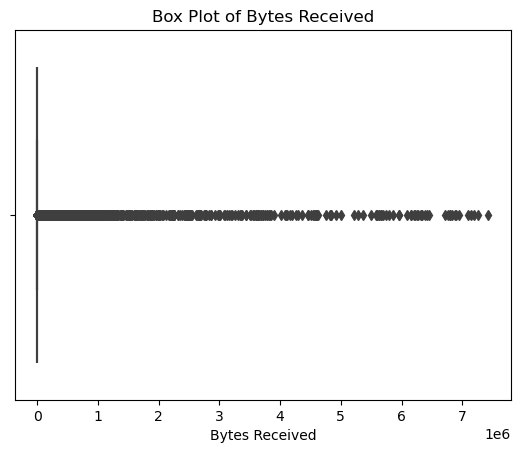

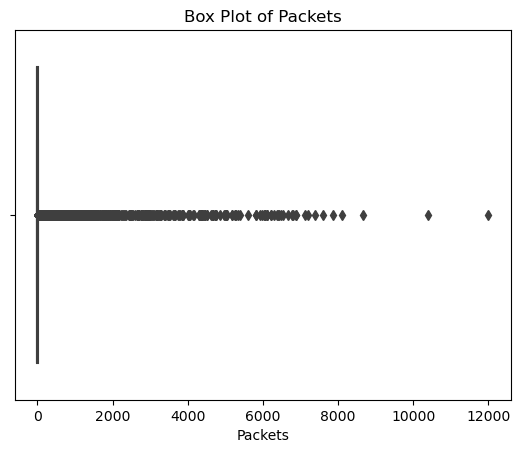

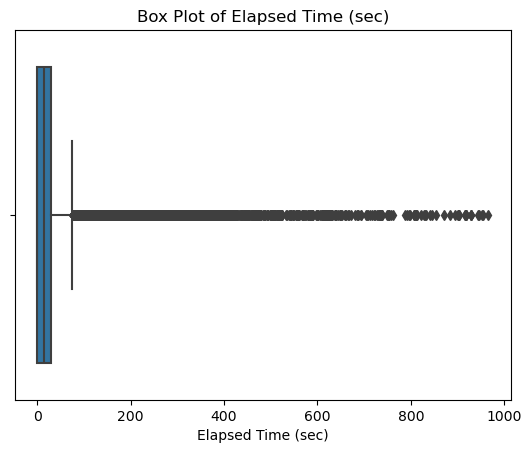

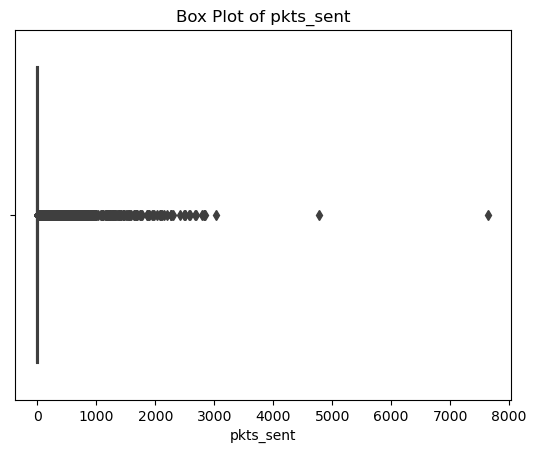

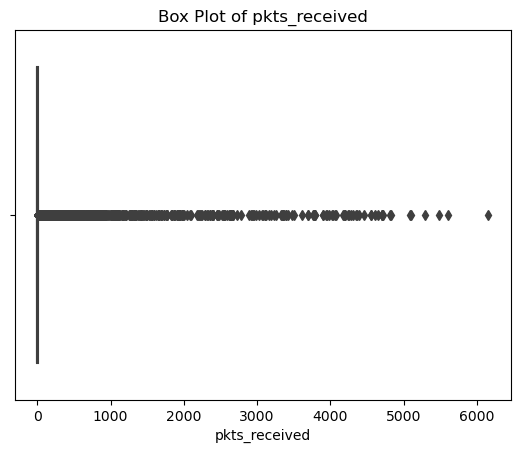

In [13]:
numerical_columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

for column in numerical_columns:
    sns.boxplot(x=column, data=df_clean)
    plt.xlabel(column)
    plt.title(f'Box Plot of {column}')
    plt.show()

In [14]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [15]:
df_clean.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,62293.000000,62293.000000,62293.000000,62293.000000,6.229300e+04,6.229300e+04,6.229300e+04,62293.000000,62293.000000,62293.000000,62293.000000
mean,49495.441880,9235.399772,18546.855505,918.185623,2.220650e+04,1.625040e+03,2.058146e+04,28.635657,32.247219,11.367923,17.267735
std,15287.283781,17386.160610,21890.294716,4197.453356,2.411910e+05,1.826577e+04,2.343550e+05,248.837291,68.387061,89.286668,167.568596
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000,0.000000,1.000000,0.000000
25%,49217.000000,53.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000,0.000000,1.000000,0.000000
50%,53962.000000,443.000000,6435.000000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000,15.000000,1.000000,1.000000
75%,58638.000000,5900.000000,37174.000000,80.000000,7.540000e+02,2.000000e+02,4.700000e+02,5.000000,30.000000,3.000000,2.000000
max,65534.000000,65504.000000,65535.000000,31774.000000,7.644833e+06,2.639957e+06,7.429337e+06,11999.000000,966.000000,7647.000000,6155.000000


## Treating Bytes

We can see in the Boxplot below that there are 4 data points that are outliers and can affect our results, so we will drop all the values above a certain range (200 million bytes). This will prevent that the outlining values influence any of our predictions. We should do this with all the numerical columns

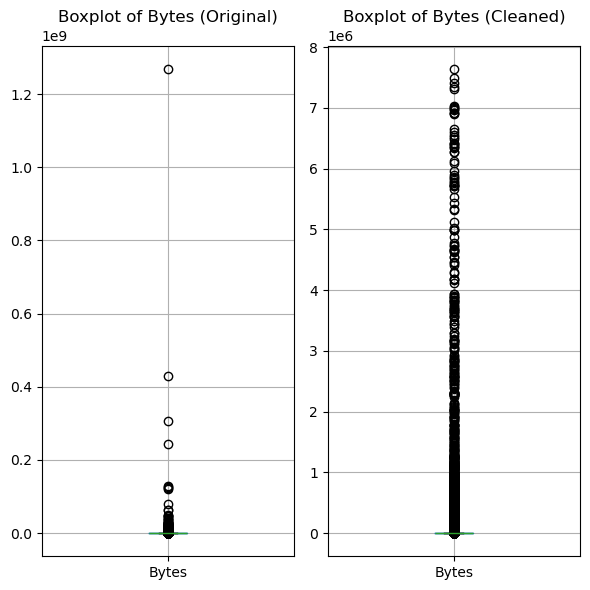

In [16]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Bytes')
plt.title('Boxplot of Bytes (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Bytes')
plt.title('Boxplot of Bytes (Cleaned)')

plt.tight_layout()
plt.show()

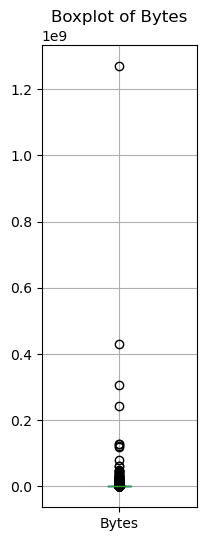

In [17]:
# Dropping outliers
df.drop(df[df['Bytes'] > 2_000_000_000].index, inplace=True)

plt.figure(figsize=(2, 6))
df.boxplot(column='Bytes')
plt.title('Boxplot of Bytes')
plt.show()

------------------------------------------

## Treating Bytes Sent

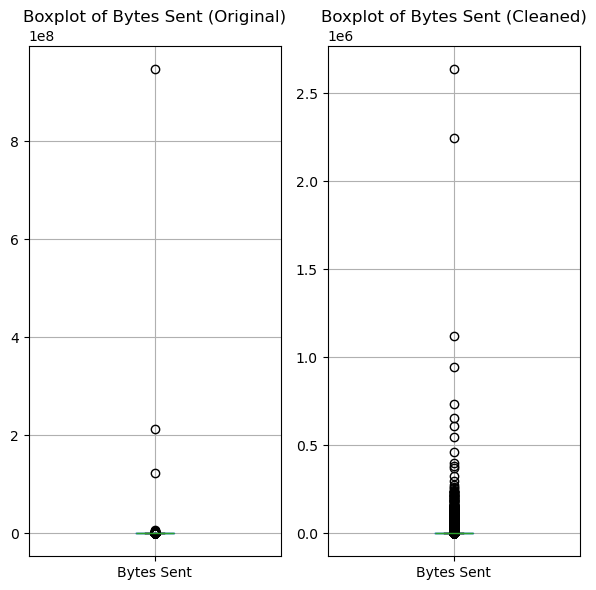

In [18]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Bytes Sent')
plt.title('Boxplot of Bytes Sent (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Bytes Sent')
plt.title('Boxplot of Bytes Sent (Cleaned)')

plt.tight_layout()
plt.show()

----------------

##  Treating Bytes Received

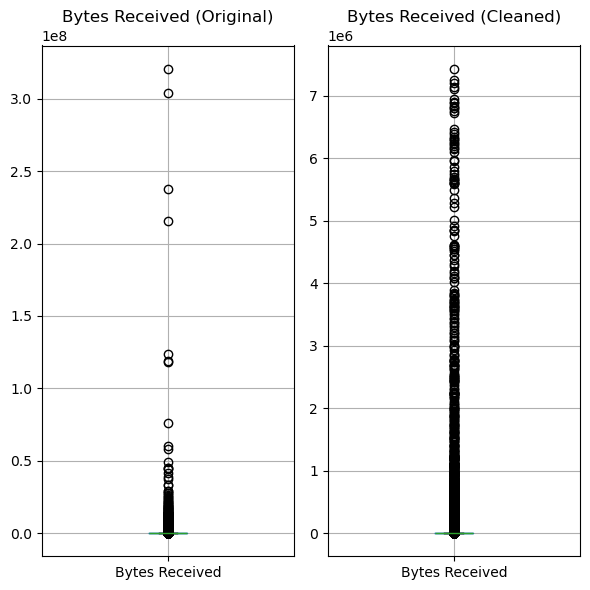

In [19]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Bytes Received')
plt.title('Bytes Received (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Bytes Received')
plt.title('Bytes Received (Cleaned)')

plt.tight_layout()
plt.show()

--------------------

## Treating Packets

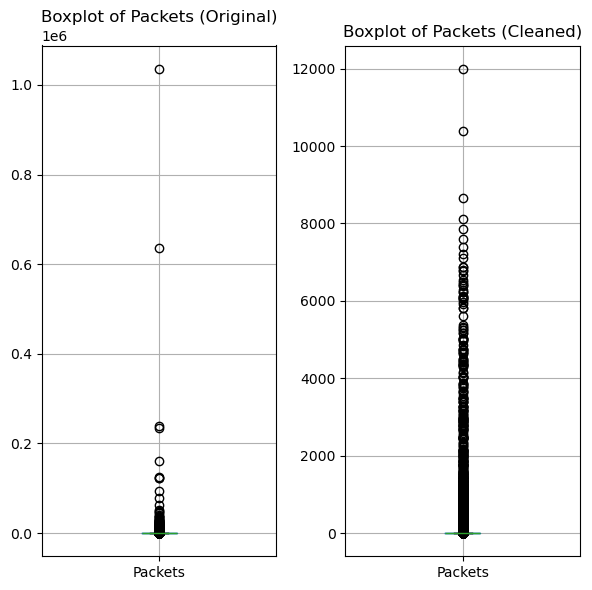

In [20]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Packets')
plt.title('Boxplot of Packets (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Packets')
plt.title('Boxplot of Packets (Cleaned)')

plt.tight_layout()
plt.show()

----------------

## Treating Elapsed Time (sec)

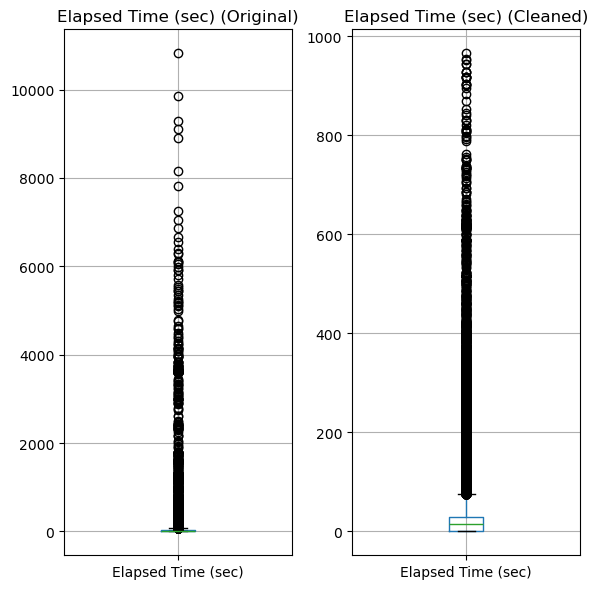

In [21]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Elapsed Time (sec)')
plt.title('Elapsed Time (sec) (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Elapsed Time (sec)')
plt.title('Elapsed Time (sec) (Cleaned)')

plt.tight_layout()
plt.show()

--------------

## Treating pkts_sent

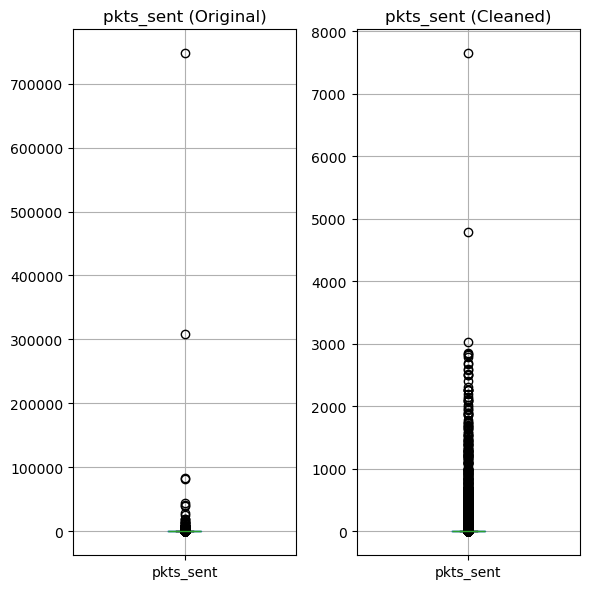

In [22]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='pkts_sent')
plt.title('pkts_sent (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='pkts_sent')
plt.title('pkts_sent (Cleaned)')

plt.tight_layout()
plt.show()

-----------

## Treating pkts_received

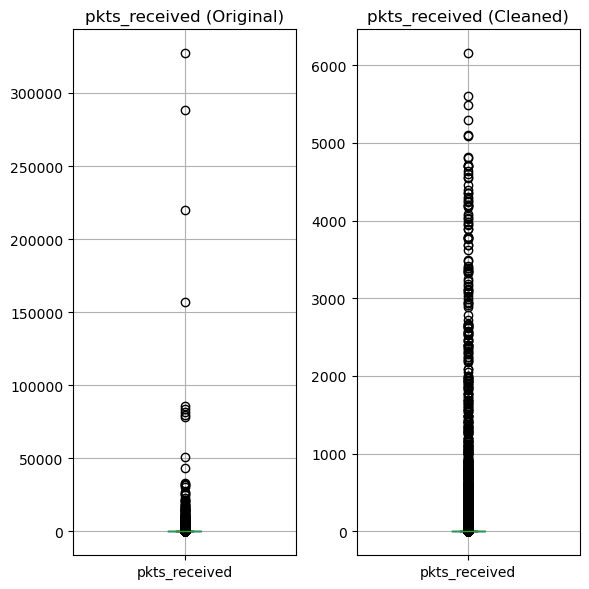

In [23]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='pkts_received')
plt.title('pkts_received (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='pkts_received')
plt.title('pkts_received (Cleaned)')

plt.tight_layout()
plt.show()

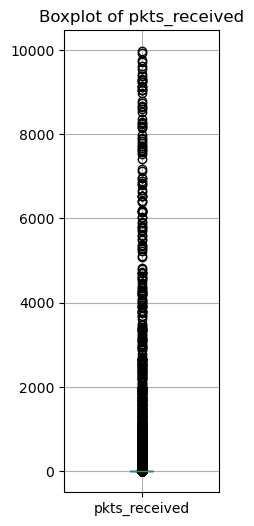

In [24]:
# Dropping outliers
df.drop(df[df['pkts_received'] > 10_000].index, inplace=True)

plt.figure(figsize=(2, 6))
df.boxplot(column='pkts_received')
plt.title('Boxplot of pkts_received')
plt.show()

-----------

In [25]:
#RFE feature elimination method - this helps on selecting which features should be used for model building
# chi-square test which columns to use in the model

#Ideas of Algorithm
#RandomForest
#XGBoost
#KNN


## RFE

In [26]:
model = RandomForestClassifier()
X = df_encoded.drop(columns=['Action_allow', 'Action_deny',	'Action_drop', 'Action_reset-both'])
y = df_encoded[['Action_allow', 'Action_deny', 'Action_drop', 'Action_reset-both']]


rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': rfe.support_, 'Rank': rfe.ranking_})
print("Selected Features:")
print(selected_features[selected_features['Selected']])

NameError: name 'df_encoded' is not defined

## Random Forest

In [ ]:
X = df_encoded[['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']]
y = df_encoded[['Action_allow', 'Action_deny', 'Action_drop', 'Action_reset-both']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#mse = np.mean(np.logical_xor(y_test, y_pred))
#print("Loss of data:", mse)

#mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)

mse_allow = np.mean(np.logical_xor(y_test_values[:, 0], y_pred_values[:, 0]))
mse_deny = np.mean(np.logical_xor(y_test_values[:, 1], y_pred_values[:, 1]))
mse_drop = np.mean(np.logical_xor(y_test_values[:, 2], y_pred_values[:, 2]))
mse_reset_both = np.mean(np.logical_xor(y_test_values[:, 3], y_pred_values[:, 3]))

print("MSE for Action_allow:", mse_allow)
print("MSE for Action_deny:", mse_deny)
print("MSE for Action_drop:", mse_drop)
print("MSE for Action_reset-both:", mse_reset_both)

In [ ]:
len(X_train)

In [ ]:
len(X_test)

In [ ]:
X = df_encoded[['Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Elapsed Time (sec)']]
y = df_encoded[['Action_allow', 'Action_deny', 'Action_drop', 'Action_reset-both']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

## KNN

In [ ]:
X = df_encoded[['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']]
y = df_encoded[['Action_allow', 'Action_deny', 'Action_drop', 'Action_reset-both']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)